# Sage Advice: *Can Remote Sensing Data Inform Sagebrush Conservation?*

Authors: 
<div>Sarah Jaffe, CU Boulder Environmental Studies</div>
<div>Kelsey Beckrich, CU Boulder Earth Data Analytics</div>
In Partnership with NatureServe

## Why sagebrush?
Sagebrush habitats support hundreds of species of plants and animals while also regulating soil quality and watersheds for millions of acres across the Western United States. While sagebrush still has an extensive range, it has been massively fragmented by commercial land use and invasive cheatgrass. This fragmentation means that even though the range of sagebrush is still extensive, its overall suitability to provide forage and shelter to the many species that depend on it is sharply reduced.  Fragmented and reduced sagebrush habitat has very real impacts - see below for the change in Greater Sage Grouse range, an obligate sagebrush inhabitant. 
<img src="https://nca2014.globalchange.gov/sites/report/files/images/web-large/Figure-19.7-hi.jpg" alt="Current and Historical Sage Grouse Habitat Distribution" width="400"/>
</div>
<center>Figure: The current and historical habitat distributions of the Greater Sage Grouse</center>
<center>Image Source: <a href="https://nca2014.globalchange.gov/sites/report/files/images/web-large/Figure-19.7-hi.jpg" target="_blank">Aldridge et al. 2008</a> </center>

This leaves us with a significant challenge – how can we monitor millions of acres of sagebrush habitat? Clearly, finding and monitoring sagebrush is a huge task through traditional field techniques. Consequently, we examined the ability different remote sensing products to detect and reconstruct sagebrush ecosystems. These remote sensing products would allow us to have eyes on large areas without having to send boots on the ground to find sagebrush or get a sense of their distribution and abundance. 


## Can data from remote sensing help us find sagebrush?

<img src="https://live.staticflickr.com/4420/36940014932_684e400a70_b.jpg"  width="600" height="500" alt="Sagebrush surrounded by cheatgrass"><center>Image Source:<a href="https://flic.kr/p/Yhgetb" target="_blank" > USFWS </a><br> Sagebrush surrounded by cheatgrass</center>

<p>As pictured here in early summer, Greater Sage Brush, the predominant sagebrush species, stands out as a shrub among grasses with distinctive light green leaves. In this particular image, it is surrounded by cheatgrass, which, by virtue of it's particular lifestyle, grows and dries very early in the year - much earlier than other plants. These traits stand out to us, but wanted to know whether these traits would be distinct enough to be captured by remote sensing data. Consequently, we looked for and found publicly available remote sensing data to ask the following:
</p><br>
1. Canopy Height Models - can this find a sagebrush shrub against shortgrass prarie?<br>
2. LANDSAT8 multispectral data - can satellite data see the characteristic color of sagebrush against other vegetatation and soil? Can it see the cheatgrass that has already dried up in the field?<br>
3. NEON hyperspectral data - can a plane with a finely tuned instrument see that sage green or the dried cheatgrass? does it see either any better than a satellite?<br>

From the initial data gathering to the final data analysis, we found is that there are plenty of publicly available data, but their usefulness for these particular environments varies.

First, let’s look at a Canopy Height Model developed for the National Ecological Observatory Network’s (NEON) site near the Onaqui Mountains of Utah. Then, we'll look at the results from the two spectral data options in the same region.



In [1]:
# Import packages
import os
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import urllib
import folium
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Polygon
from shapely.geometry import box
from shapely.geometry import Point
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import plotting_extent
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep

# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))
def open_ecosystem_structure(site, date):
    '''Uses API call to retrieve NEON ecosystem structure (CHM)
    data at a given site and date. Returns  list of all rasters
    within data product. For more information on NEON ecosystem 
    structure data and a full list of available dates see
    https://data.neonscience.org/data-products/DP3.30015.001
    
    Parameters
    ----------
    site : str
        4 Letter site name. See 
        https://www.neonscience.org/field-sites/field-sites-map/list
        for a full list of NEON sites
        
    date : str
        Date of data collection in yyyy-mm format
    
    Returns
    -------
    CHM_raster_tiles : .tif
        All raster .tif tiles associated with
        the site and date specified   
    '''
    data_product_url = ['https://data.neonscience.org/api/v0/data/DP3.30015.001/'
                        + site+'/'+date]
    call_response = requests.get(data_product_url[0])
    call_response.json()
    
    CHM_raster_tiles = []
    
    for i in call_response.json()['data']['files']:
        data_file_url = i['url']
        file_format = data_file_url.find('.tif')
        if not file_format == -1:
            CHM_raster_tiles.append(data_file_url)
    
    return CHM_raster_tiles


def open_woody_veg_structure(site, date):
    '''Uses API call to retrieve NEON product data for woody 
    vegetation structure. Returns pandas of merged apparent 
    individual, mapping and tagging, and per plot per year
    documents, eg one dataframe with locational, species, 
    and height data. Also returns a pandas dataframe of filtered 
    plot data to facilitate geospatial merges and calculation of
    raster stats. For more information on NEON woody vegetation 
    structure data products and available dates, see
    https://data.neonscience.org/data-products/DP1.10098.001
    
    Parameters
    ----------
    site : str
        4 Letter site name. See 
        https://www.neonscience.org/field-sites/field-sites-map/list
        for a full list of NEON sites
    
    date : str
        Date of data collection in yyyy-mm format
    
    Returns
    -------
    all_merged_df : pandas.core.frame.DataFrame
        Pandas dataframe of merged measurement, plot, and mapping
        tabular files from data product
    
    plot_df : pandas.core.frame.DataFrame
        Pandas dataframe of perplotperyear.csv locational data
    '''
    data_product_url = ['https://data.neonscience.org/api/v0/data/DP1.10098.001/'
                        + site+'/'+date]
    call_response = requests.get(data_product_url[0])
    
    all_urls = []
    
    for i in call_response.json()['data']['files']:
        data_file_url = i['url']
        height_find = data_file_url.find('individual')
        plot_find = data_file_url.find('perplot')
        map_find = data_file_url.find('mapping')
        
        if not height_find == -1:
            apparent_df = pd.read_csv(data_file_url)
        elif not plot_find == -1:
            plot_df = pd.read_csv(data_file_url)
        elif not map_find == -1:
            map_df = pd.read_csv(data_file_url)
    
    apparent_df = apparent_df[[
        'plotID', 'individualID', 'height']]
    
    plot_df = plot_df[['plotID', 'plotType',
                       'decimalLatitude', 'decimalLongitude',
                       'easting', 'northing']]
    
    map_df = map_df[['plotID', 'individualID', 'scientificName']]
    
    measurement_map_merge = pd.merge(
        apparent_df, map_df, on=['plotID', 'individualID'])
    all_merged_df = pd.merge(plot_df, measurement_map_merge, on='plotID')
    
    return all_merged_df, plot_df


def NEON_site_extent(path_to_NEON_boundaries, site):
    '''Extracts a NEON site extent from an individual site as
    long as the original NEON site extent shape file contains 
    a column named 'siteID'.

    Parameters
    ----------
    path_to_NEON_boundaries : str
        The path to a shape file that contains the list
        of all NEON site extents, also known as field
        sampling boundaries (can be found at NEON and
        ESRI sites)

    site : str
        One siteID contains 4 capital letters, 
        e.g. CPER, HARV, ONAQ or SJER.

    Returns
    -------
    site_boundary : geopandas.geodataframe.GeoDataFrame
        A vector containing a single polygon 
        per the site specified.        
    '''
    NEON_boundaries = gpd.read_file(path_to_NEON_boundaries)
    boundaries_indexed = NEON_boundaries.set_index(['siteID'])

    site_boundary = boundaries_indexed.loc[[site]]
    site_boundary.reset_index(inplace=True)

    return site_boundary


def buffer_point_plots(df, crs, buffer):
    '''Creates geodataframe from plot points
    within a designated coordinate reference system. 
    Buffers plot points to a given radius. Compatible
    with most NEON tabular plot data files including
    northing and easting locational columns. Final product
    can be used to visualize plot locations or combined 
    with other spatial data products.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        df including Northing and Easting plot locations
    
    crs : str or rasterio.crs.CRS
        String of desired coordinate reference system
    
    buffer : int
        Desired radius for final plot polygons
    
    Returns
    -------
    buffered_gdf : geopandas.geodataframe.GeoDataFrame
       Dataframe with point plots buffered to polgyons
    '''
    buffered_gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(
            x=df.easting, y=df.northing), crs=crs)
    
    buffered_gdf['geometry'] = buffered_gdf.geometry.buffer(buffer)
    
    return(buffered_gdf)


def tiles_over_insitu_plots(tiles, plots):
    '''Takes a list of raster images and geodataframe
    of plot polygons within the same CRS. Cross references
    overlap between raster extent polygon and plot point 
    polygons. Returns list of .tiff file locations that 
    overlap completely with plot polygons.
    ----------
    tiles : list
        List of rasters
    
    plots : geopandas.geodataframe.GeoDataFrame
        Geodataframe with polygons of AOI plots
    
    Returns
    -------
    target_rasters : list
        List of strings with to raster locations
    '''
    target_rasters = []
    
    insitu_plot_size = plots.loc[0, 'geometry'].area
    
    for tile in tiles:
        with rio.open(tile) as src:
            extent = plotting_extent(src)
        raster_polygon = Polygon([
            [extent[0], extent[2]],
            [extent[0], extent[3]],
            [extent[1], extent[3]],
            [extent[1], extent[2]]])
        raster_polygon_gdf = gpd.GeoDataFrame(crs=src.crs,
                                              geometry=[raster_polygon])
        raster_plot_intersection = gpd.overlay(
            raster_polygon_gdf, plots, how='intersection')
        
        if raster_plot_intersection['geometry'].empty:
            pass
        elif int(
                raster_plot_intersection.loc[0, 'geometry'].area) == int(
                insitu_plot_size):
            target_rasters.append(tile)
    
    return target_rasters




## Study Area: Onaqui, Utah

In [28]:


# Download shapefile of all NEON site boundaries
url = 'https://www.neonscience.org/neon-terrestrial-field-site-boundaries-shapefile'
et.data.get_data(url=url, replace=True)

# Create path to shapefile
terrestrial_sites = os.path.join(
    'data', 'earthpy-downloads',
    'fieldSamplingBoundaries (1)',
    'terrestrialSamplingBoundaries.shp')
# Import insitu plot data for CPER and ONAQ sites

ONAQ_insitu_df, ONAQ_plots = open_woody_veg_structure(
    site='ONAQ', date='2017-09')

ONAQ_tif_files = open_ecosystem_structure(
    site='ONAQ', date='2017-06')
with rio.open(ONAQ_tif_files[0]) as ONAQ_src:
    ONAQ_crs = ONAQ_src.crs

# Create geodataframes with buffered plot points
ONAQ_insitu_gdf = buffer_point_plots(
    df=ONAQ_insitu_df, crs=ONAQ_crs, buffer=40)
# Import shapefile of NEON site
ONAQ_site_outline = NEON_site_extent(
    path_to_NEON_boundaries=terrestrial_sites, site='ONAQ')
# Convert site outline and plot points to JSONs
ONAQ_plot_locations_json = ONAQ_insitu_gdf.to_crs(epsg=4326).to_json()
ONAQ_site_outline_json = ONAQ_site_outline.to_crs(epsg=4326).to_json()

# Create interactive map with ONAQ site outline and plot points
ONAQ_map = folium.Map([40.17759, -112.45244],
                      zoom_start=8,
                      tiles='Stamen Toner')
ONAQ_points = folium.features.GeoJson(
    ONAQ_plot_locations_json, tooltip='ONAQ Site')
ONAQ_site = folium.features.GeoJson(ONAQ_site_outline_json)

ONAQ_map.add_child(ONAQ_site).add_child(ONAQ_points)
ONAQ_map

# Sagebrush and Canopy Height Models

While Canopy Height Models (CHM) are available from NEON, we found they cannot detect sagebrush since NEON removes all vegetation measuring under 2 meters when creating their CHM from raw LIDAR data. Removing data within this height range improves the accuracy for forested areas, but eliminates meaningful data for ecosystems with shorter vegetation. Therefore, it is questionable whether providing LIDAR CHM for shrub/shortgrass ecosystems is worthwhile with current practices.


In [ ]:
ONAQ_AOI_tifs = tiles_over_insitu_plots(
    tiles=ONAQ_tif_files, plots=ONAQ_insitu_gdf)
with rio.open(ONAQ_AOI_tifs[0]) as ONAQ_src:
    ONAQ_CHM = ONAQ_src.read(1, masked=True)
    ONAQ_extent = plotting_extent(ONAQ_src)


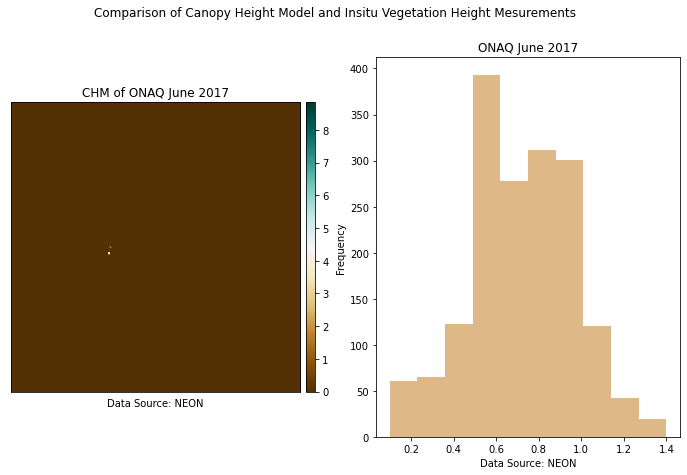

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 7))
fig.suptitle('Comparison of Canopy Height Model and Insitu Vegetation Height Mesurements')
ep.plot_bands(ONAQ_CHM, cmap='BrBG', ax=ax1,
              title='CHM of ONAQ June 2017',
              scale=False)
ax1.text(0.5,-0.05,'Data Source: NEON',ha='center',transform=ax1.transAxes, fontsize=10)
ONAQ_insitu_gdf['height'].plot.hist(
    ax=ax2, color=['burlywood'],
    title='ONAQ June 2017')
ax2.text(0.5,-0.075,'Data Source: NEON',ha='center',transform=ax2.transAxes, fontsize=10)
plt.show()

## Sagebrush and Spectral Data 

